In [1]:
! pip install -q kaggle
!pip install h5py

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                    title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                        DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           2049        197  1.0              
muhammadbinimran/housing-price-prediction-data         Housing Price Prediction Data               763KB  2023-11-21 17:56:32           9325        162  1.0              
thedrcat/daigt-proper-train-dataset                    DAIGT Proper Train Dataset                  119MB  2023-11-05 14:03:25           1885        153  1.0              
thedevastator/books-sales-and-ratings                  Books Sales and Ratings                      53KB  2023-12-06 04:54:33           2285     

In [ ]:
!kaggle datasets download -d sadmansakibmahi/plant-disease-expert

In [ ]:
!unzip /content/plant-disease-expert.zip

In [ ]:
import os
import shutil

dataset_path = '/content/Image Data base'

# we will work in this new dataset
new_dataset_path = '/content/NewDataset'

# Create the new dataset directory if it doesn't exist
os.makedirs(new_dataset_path, exist_ok=True)

# Your working_class_labels
working_class_labels = ['Pepper bell Bacterial spot', 'Pepper bell healthy', 'Potato Early blight',
                        'Potato Late blight', 'Potato healthy', 'Tomato Early blight', 'Tomato Late blight',
                        'Tomato Leaf Mold', 'Tomato Septoria leaf spot',
                        'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot',
                        'Tomato Tomato mosaic virus', 'Tomato healthy', 'potato hollow heart']

# Loop through the working_class_labels and move files to the new dataset directory
for label in working_class_labels:
    label_path = os.path.join(new_dataset_path, label)
    os.makedirs(label_path, exist_ok=True)

    # Filter files based on the label
    files_to_move = [f for f in os.listdir(dataset_path) if label.lower() in f.lower()]

    # Move the files to the new directory
    for file_name in files_to_move:
        src_path = os.path.join(dataset_path, file_name)
        dest_path = os.path.join(label_path, file_name)
        shutil.copy2(src_path, dest_path)

print("New dataset created successfully.")


In [6]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

In [7]:
dataset_path = new_dataset_path
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


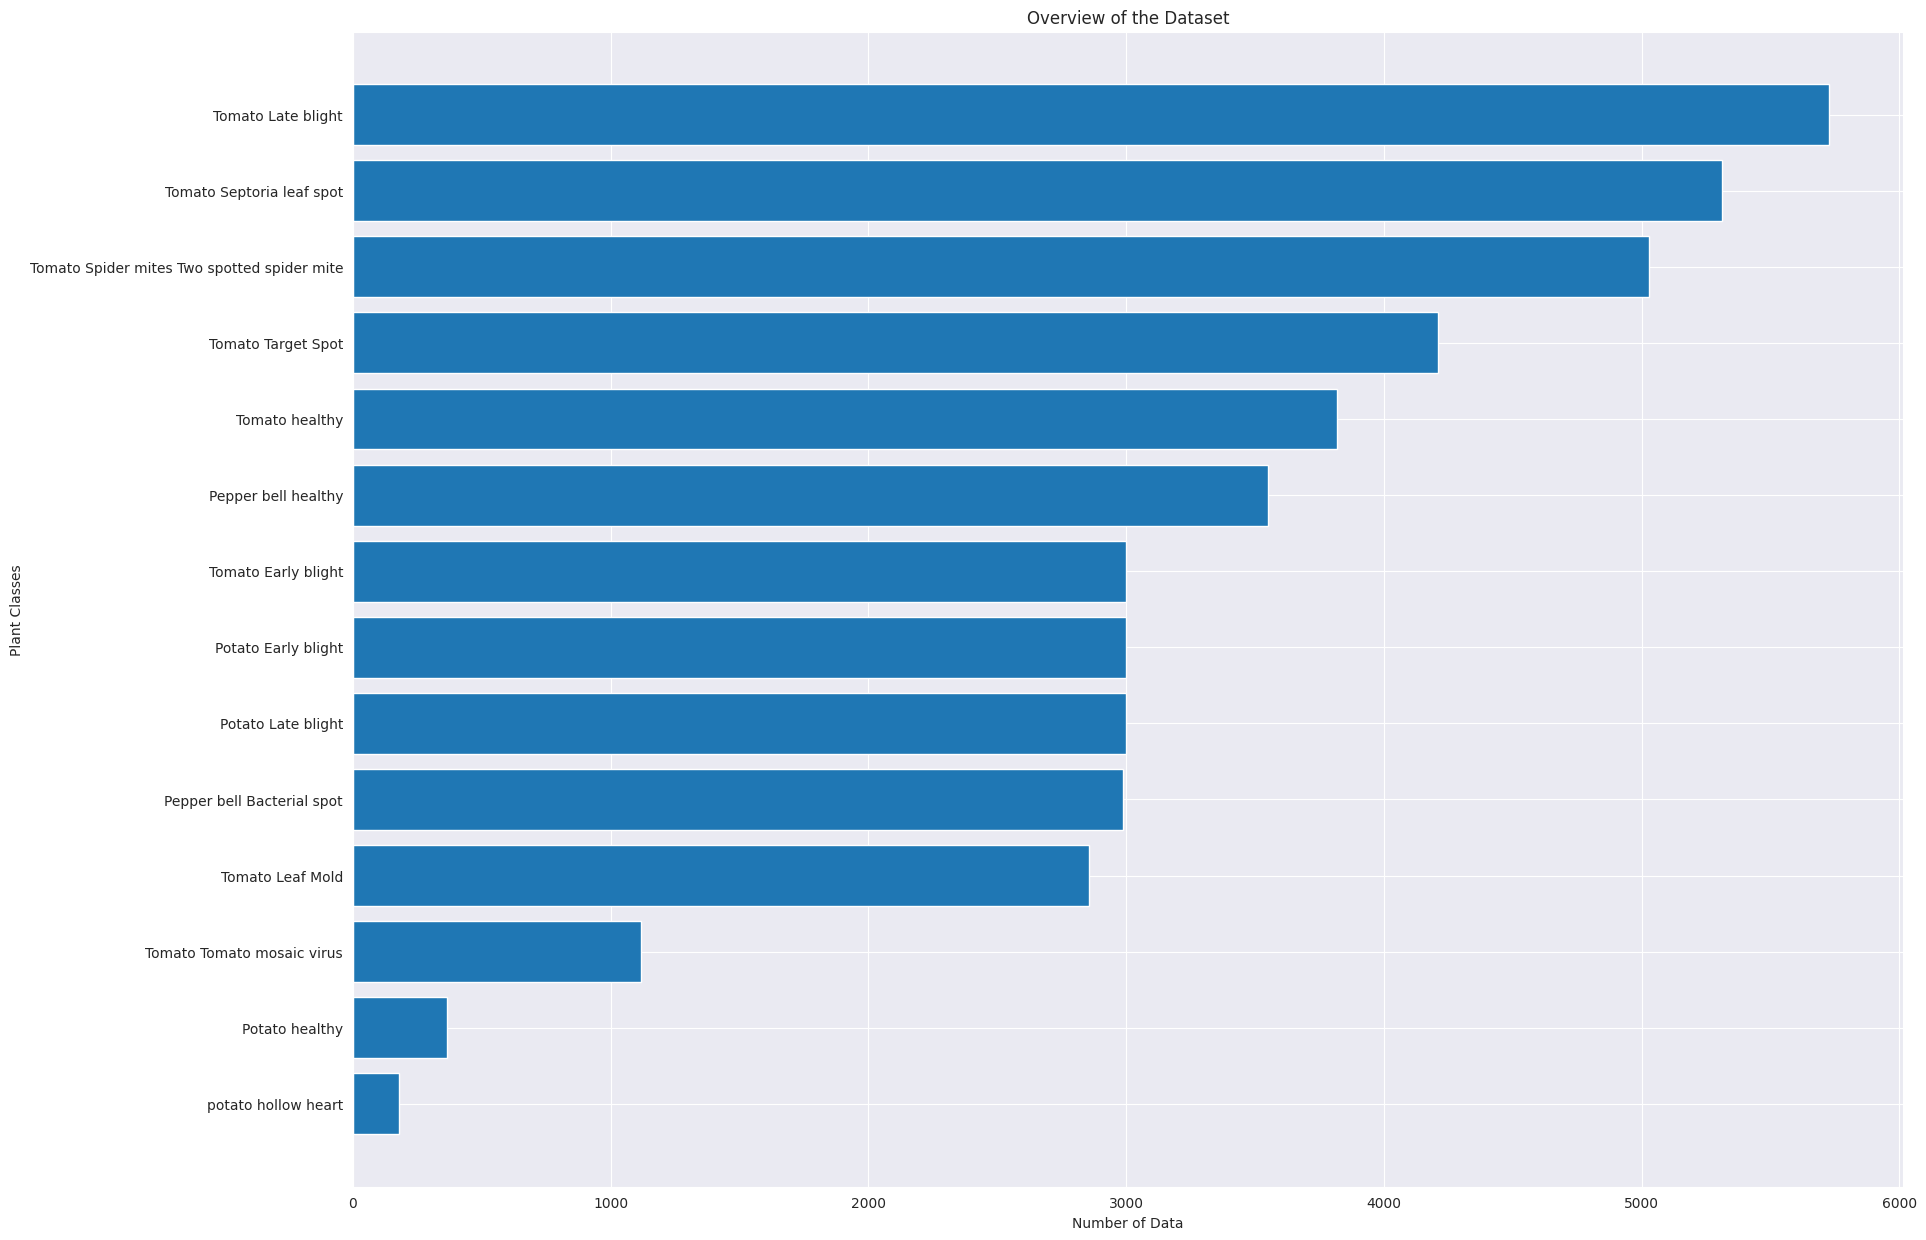

//////////////////////////////
                   Plant Class  Number of Images
8          potato hollow heart               180
9               Potato healthy               366
4   Tomato Tomato mosaic virus              1119
6             Tomato Leaf Mold              2856
11  Pepper bell Bacterial spot              2988
//////////////////////////////
train_df lenght:  39741   test_df length:  2208   valid_df length:  2208
The number of classes in the dataset is:  14
            CLASS               IMAGE COUNT 
  Pepper bell Bacterial spot       2689     
     Pepper bell healthy           3194     
     Potato Early blight           2700     
      Potato Late blight           2700     
        Potato healthy              330     
     Tomato Early blight           2700     
      Tomato Late blight           5154     
       Tomato Leaf Mold            2570     
  Tomato Septoria leaf spot        4782     
Tomato Spider mites Two spotted spider mite     4525     
      Tomato Targe

In [8]:
directory = dataset_path

total_number = 0
total_classes = 0
name_classes = []
len_classes = []

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        len_classes.append(num_files)
        name_classes.append(folder)
        total_number += num_files
        total_classes += 1

data = {'Plant Class': name_classes, 'Number of Images': len_classes}

df = pd.DataFrame(data)
df_sorted = df.sort_values('Number of Images')

plt.figure(figsize=(20, 15))
plt.barh(df_sorted['Plant Class'], df_sorted['Number of Images'])
plt.title('Overview of the Dataset')
plt.xlabel('Number of Data')
plt.ylabel('Plant Classes')
plt.show()
print("//////////////////////////////")
min_classes = df_sorted.head(5)
print(min_classes[['Plant Class', 'Number of Images']])



print("//////////////////////////////")

sdir=(dataset_path)
min_samples=40 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

In [9]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples= 198855 # since each class has more than 198855 images all classes will be trimmed to have 50000 images per class
min_samples=36
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  198855  and the minimum samples in any class is  36


In [10]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size= (200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size= (200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)


print("Total Train Image:-",len(train_df))
print("Total Validation Image:-",len(valid_df))
print("Total Test Image:-",len(test_df))

Found 39741 validated image filenames belonging to 14 classes.
Found 2208 validated image filenames belonging to 14 classes.
Found 2208 validated image filenames belonging to 14 classes.
test batch size:  69   test steps:  32  number of classes :  14
Total Train Image:- 39741
Total Validation Image:- 2208
Total Test Image:- 2208


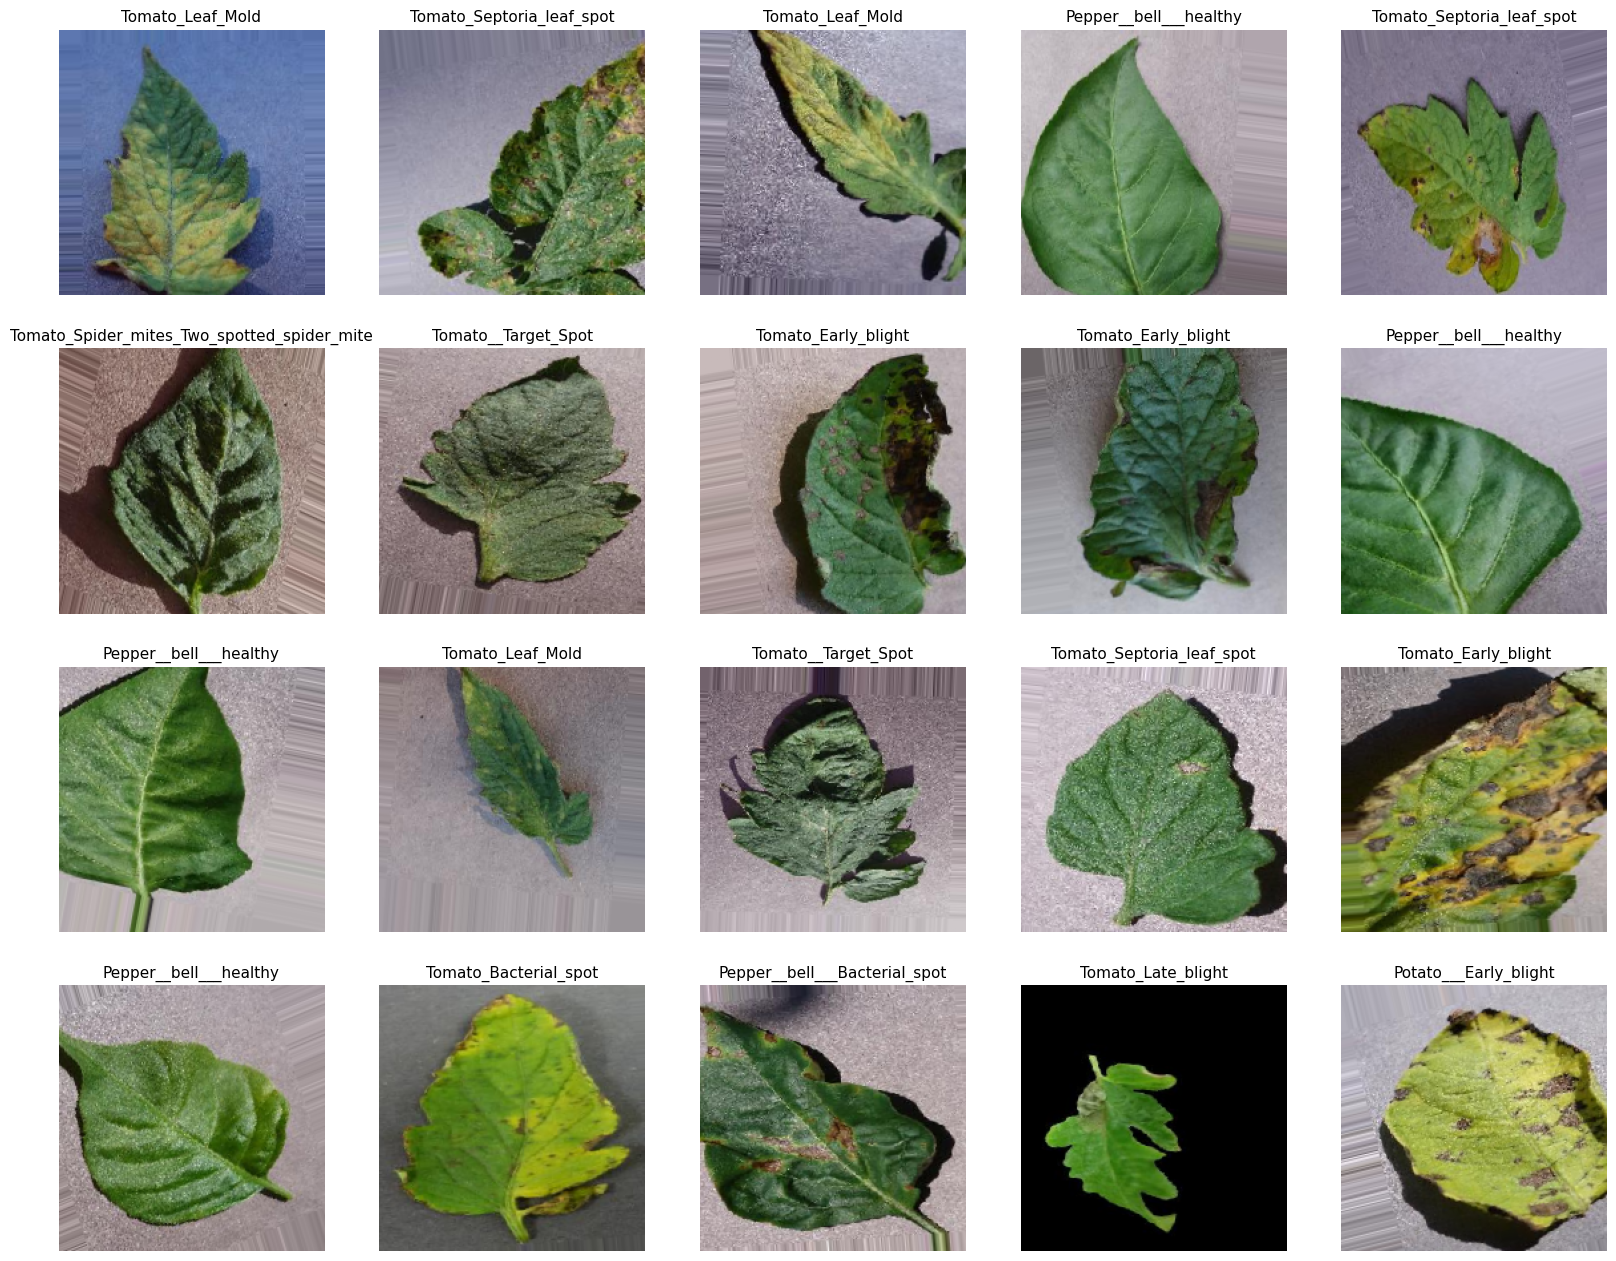

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=11)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3

# Assuming df contains the file paths and labels
# Adjust the input shape based on the requirements of EfficientNetB3
input_shape = (300, 300, 3)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Create an instance of the EfficientNetB3 model pre-trained on ImageNet data
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build your model on top of the EfficientNetB3 base
num_classes = len(train_df['labels'].unique())
model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
batch_size = 32
trgen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
tgen = ImageDataGenerator(rescale=1./255)

train_gen = trgen.flow_from_dataframe(dataframe=train_df, directory=None,
                                      x_col='filepaths', y_col='labels',
                                      target_size=(input_shape[0], input_shape[1]),
                                      class_mode='categorical',
                                      batch_size=batch_size)

test_gen = tgen.flow_from_dataframe(dataframe=test_df, directory=None,
                                    x_col='filepaths', y_col='labels',
                                    target_size=(input_shape[0], input_shape[1]),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=False)




44107200/44107200 [==============================] - 0s 0us/step
Found 35325 validated image filenames belonging to 14 classes.
Found 8832 validated image filenames belonging to 14 classes.


# **Train the model**

In [ ]:
# Train the model
epochs = 6  # Adjust the number of epochs as needed
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_gen,
                    validation_steps=test_gen.samples // batch_size)



# **Additional Training or model re_Training**

In [ ]:
# Additional Training
additional_epochs = 10  # Adjust the number of additional epochs as needed
history_additional = model.fit(train_gen,
                               steps_per_epoch=train_gen.samples // batch_size,
                               epochs=additional_epochs,
                               validation_data=test_gen,
                               validation_steps=test_gen.samples // batch_size)


Epoch 1/10
1103/1103 [==============================] - 967s 866ms/step - loss: 0.3560 - accuracy: 0.8748 - val_loss: 0.1771 - val_accuracy: 0.9367
Epoch 2/10
1103/1103 [==============================] - 922s 836ms/step - loss: 0.3426 - accuracy: 0.8807 - val_loss: 0.1682 - val_accuracy: 0.9428
Epoch 3/10
1103/1103 [==============================] - 910s 825ms/step - loss: 0.3345 - accuracy: 0.8820 - val_loss: 0.1593 - val_accuracy: 0.9467
Epoch 4/10
1103/1103 [==============================] - 926s 840ms/step - loss: 0.3344 - accuracy: 0.8815 - val_loss: 0.1624 - val_accuracy: 0.9424
Epoch 5/10
1103/1103 [==============================] - 918s 832ms/step - loss: 0.3228 - accuracy: 0.8873 - val_loss: 0.1708 - val_accuracy: 0.9411
Epoch 6/10
1103/1103 [==============================] - 921s 835ms/step - loss: 0.3216 - accuracy: 0.8865 - val_loss: 0.1658 - val_accuracy: 0.9392
Epoch 7/10
1103/1103 [==============================] - 894s 810ms/step - loss: 0.3198 - accuracy: 0.8894 - val_

In [13]:
!pip install seaborn tabulate

# **Evaluate the model on the test set**

276/276 [==============================] - 56s 202ms/step


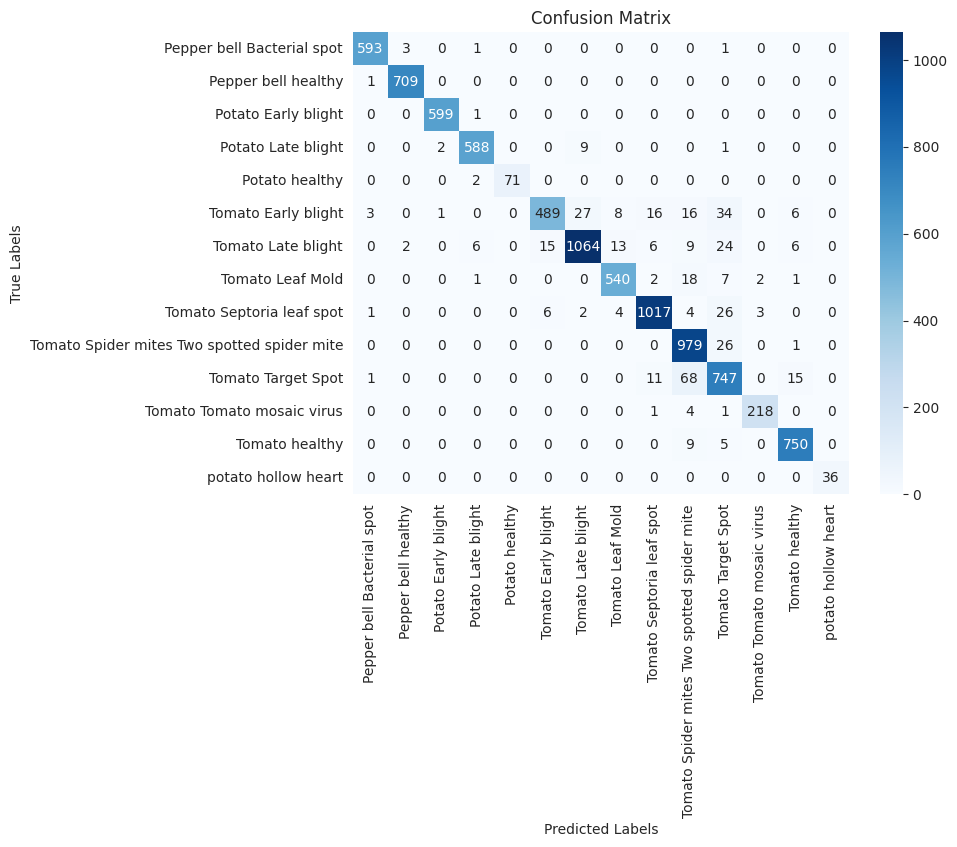

Classification Report:
                                              precision    recall  f1-score   support

                 Pepper bell Bacterial spot       0.99      0.99      0.99       598
                        Pepper bell healthy       0.99      1.00      1.00       710
                        Potato Early blight       1.00      1.00      1.00       600
                         Potato Late blight       0.98      0.98      0.98       600
                             Potato healthy       1.00      0.97      0.99        73
                        Tomato Early blight       0.96      0.81      0.88       600
                         Tomato Late blight       0.97      0.93      0.95      1145
                           Tomato Leaf Mold       0.96      0.95      0.95       571
                  Tomato Septoria leaf spot       0.97      0.96      0.96      1063
Tomato Spider mites Two spotted spider mite       0.88      0.97      0.93      1006
                         Tomato Target S

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Make predictions on the test set
y_pred = model.predict(test_gen)
y_true = test_gen.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices, yticklabels=train_gen.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a classification report
class_report = classification_report(y_true, y_pred_labels, target_names=train_gen.class_indices)

# Print Classification Report
print("Classification Report:\n", class_report)
# Evaluate the model on the test set
test_results = model.evaluate(test_gen, steps=test_gen.samples // batch_size)
print("\nTest Set Evaluation:")
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

In [ ]:
class_indices
classlist

['Pepper bell Bacterial spot',
 'Pepper bell healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Potato healthy',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'Tomato Tomato mosaic virus',
 'Tomato healthy',
 'potato hollow heart']

# **Generate predictions**

In [ ]:
# Generate predictions
predictions = model.predict(test_gen, steps=test_gen.samples // batch_size)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes

276/276 [==============================] - 37s 133ms/step


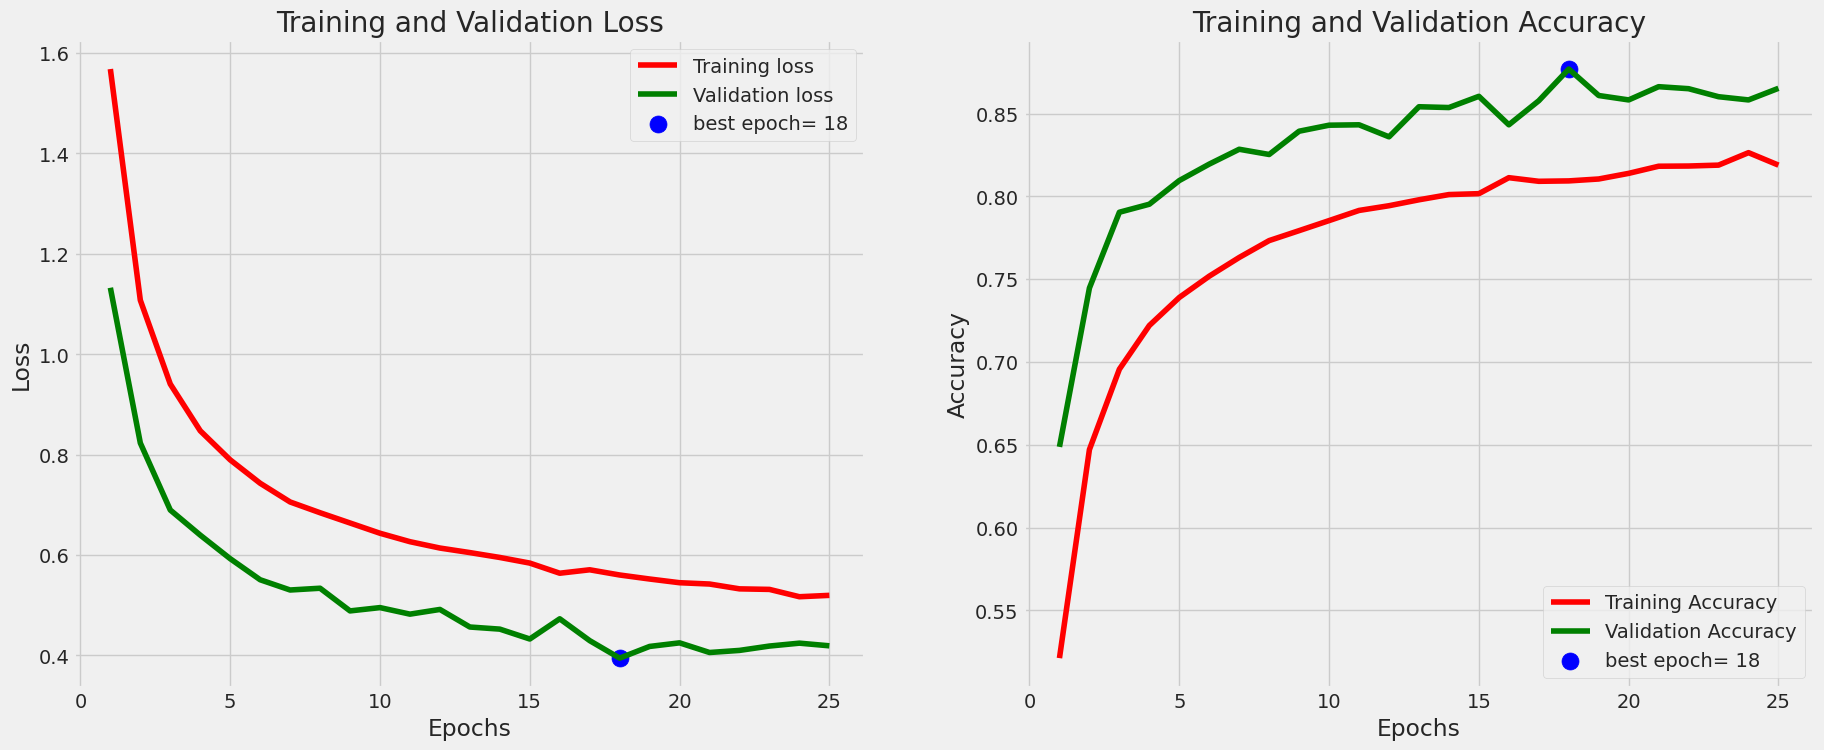

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)



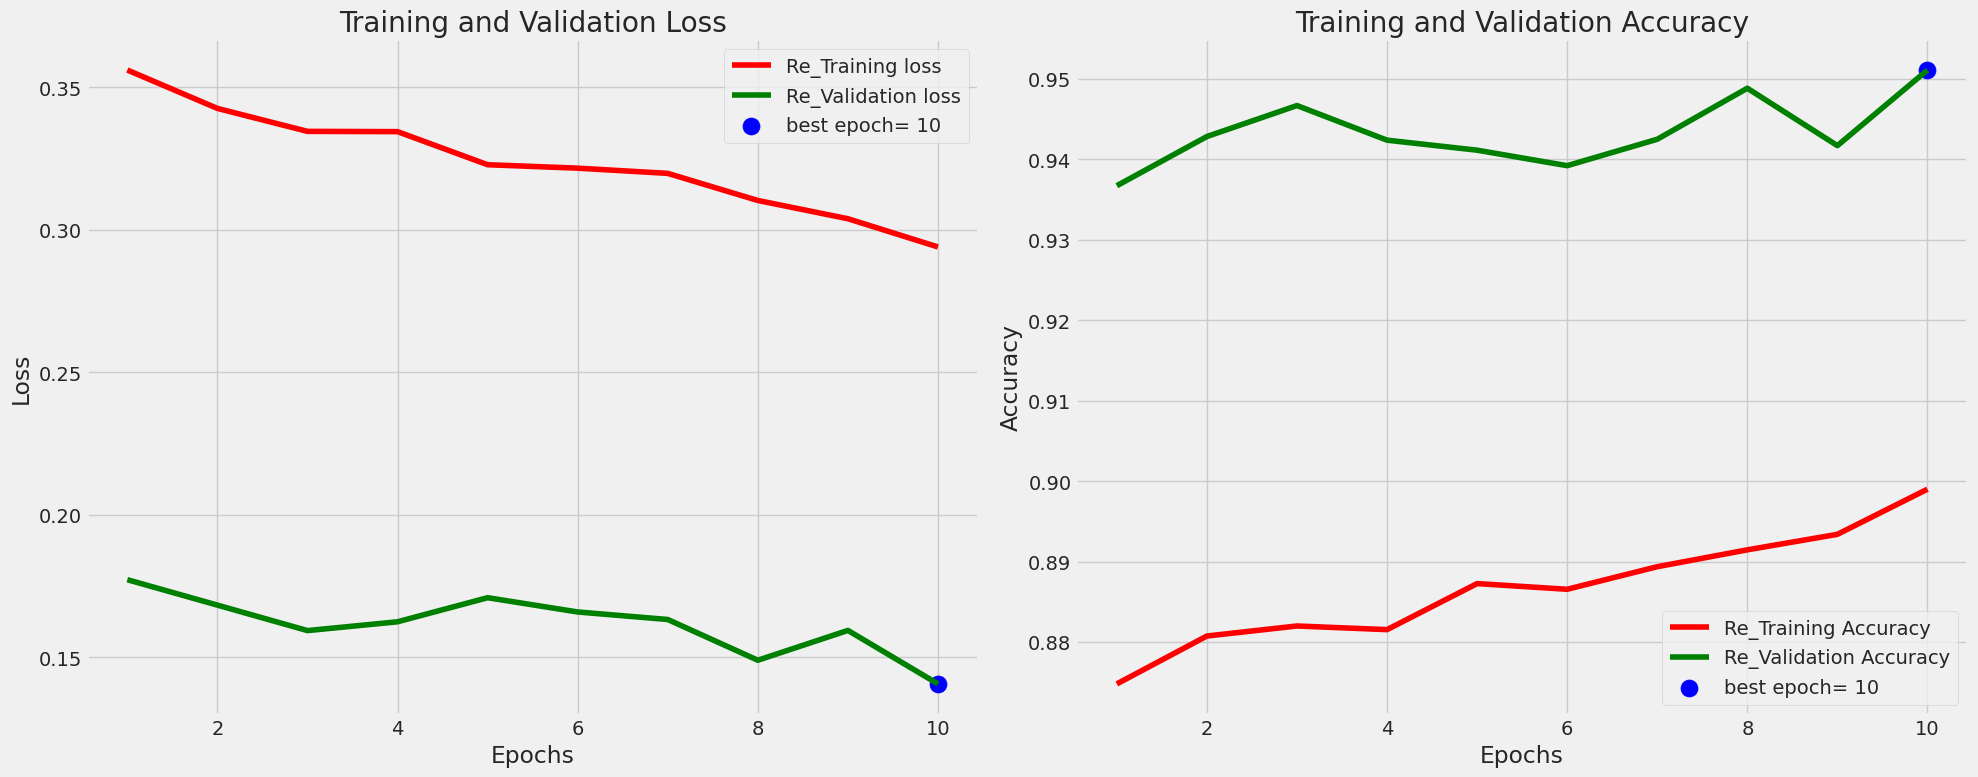

In [ ]:
def re_training_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plotting Training and Validation Loss
    axes[0].plot(Epochs, tloss, 'r', label='Re_Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Re_Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plotting Training and Validation Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Re_Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Re_Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the initial training history
re_training_plot(history_additional, 0)

# Plot the additional training history
#re_training_plot(history_additional, len(history.history['accuracy']))


# **Save the model**

In [ ]:
subject='model'
save_id= subject+ '.h5'
model_save_loc = save_id
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  model.h5


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array

def classify_image(model, image_path, class_labels):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

if __name__ == "__main__":
    # Load the saved model
    model_path = "/content/model.h5"
    loaded_model = load_model(model_path)

    # Define your class labels
    class_labels =['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy'] # Replace with your actual class labels

    # Provide the path to the image you want to classify
    image_path = "/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"

    # Perform image classification
    predicted_class, confidence = classify_image(loaded_model, image_path, class_labels)

    # Print the results
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence}")


1/1 [==============================] - 1s 1s/step
Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 0.974806547164917


# **Model Quantization**

In [12]:
Model_path = "/content/Advanced Model/EfficientNetB3 model/Main model with EfficientNetB3 model Transfer Learning/model.h5"
import tensorflow as tf
model = tf.keras.models.load_model(Model_path)

**Optimize.DEFAULT Quantization**

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model(Model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tf_lite_Optimize_DEFAULT_model = converter.convert()
print("Optimize.DEFAULT Quantization:- ",len(tf_lite_Optimize_DEFAULT_model))

Optimize.DEFAULT Quantization:-  22290748


**OPTIMIZE_FOR_SIZE Quantization**

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model(Model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float16]
OPTIMIZE_FOR_SIZE_model = converter.convert()
print("OPTIMIZE_FOR_SIZE Quantization [tf.float16]:- ",len(OPTIMIZE_FOR_SIZE_model))

OPTIMIZE_FOR_SIZE Quantization [tf.float16]:-  22290748


**OPTIMIZE_FOR_LATENCY Quantization**

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model(Model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
converter.target_spec.supported_types = [tf.float16]
OPTIMIZE_FOR_LATENCY_model = converter.convert()
print("OPTIMIZE_FOR_LATENCY Quantization:- ",len(OPTIMIZE_FOR_LATENCY_model))

OPTIMIZE_FOR_LATENCY Quantization:-  22290748


In [ ]:

with open("OPTIMIZE_FOR_SIZE_model.tflite", "wb") as f:
    f.write(OPTIMIZE_FOR_SIZE_model)

# save the DEFAULT Quantization model in HDF5 format
with open("tf_lite_Optimize_DEFAULT_model.tflite", "wb") as f:
    f.write(tf_lite_Optimize_DEFAULT_model)

# save the OPTIMIZE_FOR_LATENCY_model in HDF5 format
with open("OPTIMIZE_FOR_LATENCY_model.tflite", "wb") as f:
    f.write(OPTIMIZE_FOR_LATENCY_model)

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def classify_image_tflite(interpreter, image_path, class_labels):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    img_array = load_and_preprocess_image(image_path, target_size=(input_details[0]['shape'][1], input_details[0]['shape'][2]))

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

if __name__ == "__main__":
    # Load the TFLite model
    model_path_tflite = "/content/OPTIMIZE_FOR_SIZE_model.tflite"
    interpreter = tf.lite.Interpreter(model_path=model_path_tflite)
    interpreter.allocate_tensors()

    # Define your class labels
    class_labels = ['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']  # Replace with your actual class labels

    # Provide the path to the image you want to classify
    image_path = "/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"

    # Perform image classification using TFLite model
    predicted_class, confidence = classify_image_tflite(interpreter, image_path, class_labels)

    # Print the results
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {str(str(100*(confidence)))}")


Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 99.32006001472473
